In [1]:
!nvidia-smi

Sat Aug 22 13:52:04 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
import torch 
import torchvision
import numpy as np 
import pandas as pd
import random
import os
import glob
import copy
import cv2
from tqdm import tqdm as tqdm
from torchsummary import summary
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler

import matplotlib.pyplot as plt
from PIL import Image

# for creating validation set
from sklearn.model_selection import train_test_split

seed = 42
random.seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)
np.random.seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.manual_seed(seed)

best_model = None
best_loss = 0.
best_test_loss = 0.
best_test_acc = 0.
best_pred_labels = []
true_labels = []

pred_labels = []
test_acc = 0.
test_loss = 0.

# device = torch.device('cuda:0')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# train samples from DP data used for training
print('All Samples in Train Data')
!ls -l /content/drive/"My Drive"/APTOS/DP_Dataset/train_1 | wc -l


All Samples in Train Data
3663


In [5]:
# Copied files(DP Dataset) from drive to local, for faster training/processing

!cp -R /content/drive/"My Drive"/APTOS/DP_Dataset/train_1 ./

In [6]:
# Train samples from Non DP data, used for testing
print('All Samples in Test Data')
!ls -l /content/drive/"My Drive"/APTOS/Dataset/train_images | wc -l

All Samples in Test Data
3663


In [7]:
# Copied files(Non DP Dataset) from drive to local, for faster training/processing

!cp -R /content/drive/"My Drive"/APTOS/Dataset/train_images ./

In [8]:
!ls -lrt

total 280
drwxr-xr-x 1 root root   4096 Jul 30 16:30 sample_data
drwx------ 4 root root   4096 Aug 22 13:52 drive
drwx------ 2 root root 135168 Aug 22 14:11 train_1
drwx------ 2 root root 135168 Aug 22 14:28 train_images


In [9]:
!ls -l ./train_1 | wc -l

3663


In [10]:
!ls -l ./train_images | wc -l

3663


In [11]:
# Create APTOS Dataset class

class APTOSData(Dataset):
    def __init__(self, data_dir, df_data, transform = None):
        self.df = df_data.values
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name, label = self.df[idx]
        img_path = os.path.join(self.data_dir, img_name+'.png')
        image = cv2.imread(img_path) 
        if self.transform is not None:
            image = self.transform(image)     
        return image, label
       

In [12]:
train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(),                                          
    torchvision.transforms.Resize(256),
    torchvision.transforms.RandomAffine(0, translate=(0, 0.1), scale=(1, 1.10)),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(),                                         
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])




In [13]:
df = pd.read_csv('/content/drive/My Drive/APTOS/Dataset/train.csv')

print("Number of Labels :{}".format(len(np.unique(df['diagnosis']))))

Number of Labels :5


In [14]:

train_dataset = APTOSData('./train_images/', df , transform=train_transforms)

train_dp_dataset = APTOSData('./train_1/', df , transform=train_transforms)


In [15]:
train_idx, valid_idx= train_test_split(
    np.arange(len(train_dataset)), test_size=0.2, random_state=42, shuffle=True, stratify=df['diagnosis'])

In [16]:
print(len(valid_idx))
print(len(train_idx))

733
2929


In [17]:
# Create Samplers
# Pass train_sampler to train_dp_dataset , this gives dp images for training
# Pass valid_sampler to train_dataset, this gives non dp images for validation
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_dataloader = torch.utils.data.DataLoader(train_dp_dataset, batch_size=128, sampler = train_sampler)
val_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=128, sampler = valid_sampler)

### Original Images

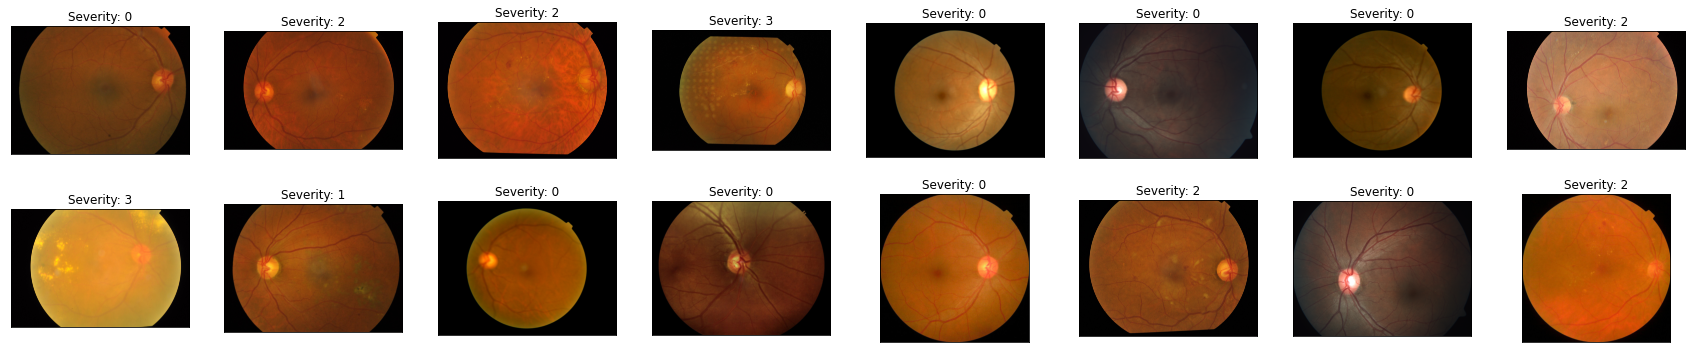

In [18]:
fig = plt.figure(figsize=(30, 6))
base_dir = '.'
# display 20 images
train_imgs = os.listdir(base_dir+"/train_images")
for idx, img in enumerate(np.random.choice(train_imgs, 16)):
    ax = fig.add_subplot(2, 16//2, idx+1, xticks=[], yticks=[])
    im = Image.open(base_dir+"/train_images/" + img)
    plt.imshow(im)
    lab = df.loc[df['id_code'] == img.split('.')[0], 'diagnosis'].values[0]
    ax.set_title('Severity: %s'%lab)

### DP Images (Epsilon = 1)

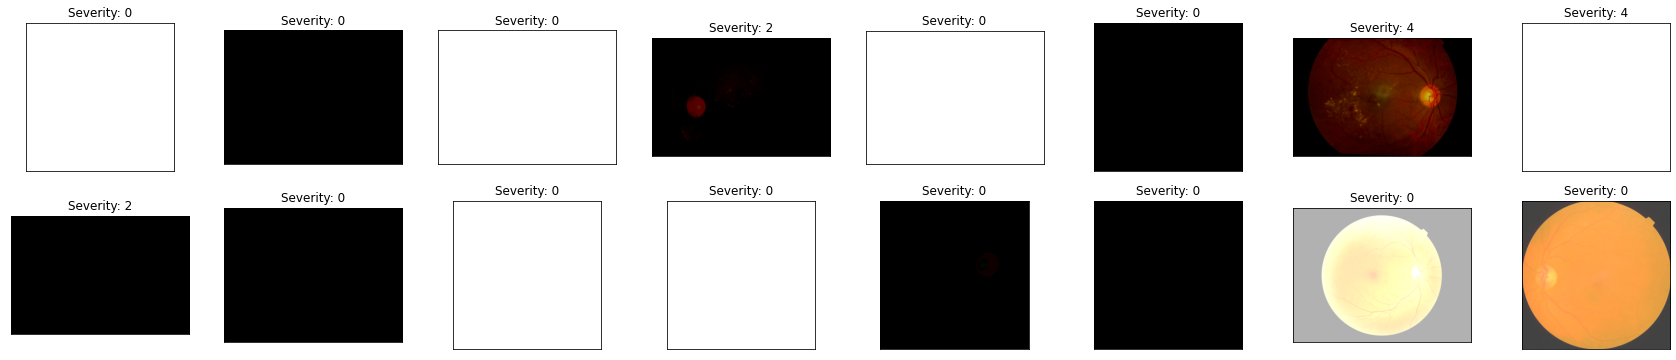

In [19]:
fig = plt.figure(figsize=(30, 6))
base_dir = '.'
# display 20 images
train_imgs = os.listdir(base_dir+"/train_1")
for idx, img in enumerate(np.random.choice(train_imgs, 16)):
    ax = fig.add_subplot(2, 16//2, idx+1, xticks=[], yticks=[])
    im = Image.open(base_dir+"/train_1/" + img)
    plt.imshow(im)
    lab = df.loc[df['id_code'] == img.split('.')[0], 'diagnosis'].values[0]
    ax.set_title('Severity: %s'%lab)

In [20]:
model = torchvision.models.resnet18(pretrained=True)
model.fc = torch.nn.Linear(in_features=512, out_features=5)
model = model.to(device)
model

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [21]:
summary(model.cuda(), [(3,224,224,)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [22]:
def run_epoch(model, dataloader, criterion, optimizer, lr_scheduler, phase='train'):
    epoch_loss = 0.
    epoch_acc = 0.
    
    batch_num = 0.
    samples_num = 0.
    
    true_labels = []
    pred_labels = []
    
    for batch_idx, (data, labels) in enumerate(dataloader):
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        if phase == 'train':
            model.train()
        else:
            model.eval()
        with torch.set_grad_enabled(phase == 'train'):
            outputs = model(data)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
        
        true_labels.append(labels.detach().cpu())
        pred_labels.append(preds.detach().cpu())
        
        if phase == 'train':
            loss.backward()
            optimizer.step()
        
        print(f'\r{phase} batch [{batch_idx}/{len(dataloader)}]: loss {loss.item()}', end='', flush=True)
        epoch_loss += loss.detach().cpu().item()
        epoch_acc += torch.sum(preds == labels.data)
        batch_num += 1
        samples_num += len(labels)
    
    print()
    return epoch_loss / batch_num, epoch_acc / samples_num, torch.cat(true_labels).numpy(), torch.cat(pred_labels).numpy()

In [23]:
criterion = torch.nn.CrossEntropyLoss()
#optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, weight_decay=0.001)
optimizer = torch.optim.SGD([{'params': [param for name, param in model.named_parameters() if 'fc' not in name]}, {'params': model.fc.parameters(), 'lr': 1e-3}], lr=5e-4, weight_decay=0.001)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, verbose=True)

In [24]:
train_losses = []
val_losses = []
#test_losses = []
output_folder = '/content/drive/My Drive/APTOS/Dataset/1/'
for epoch in range(50):
    print('='*15, f'Epoch: {epoch}')
    
    train_loss, train_acc, _, _ = run_epoch(model, train_dataloader, criterion, optimizer, lr_scheduler)
    val_loss, val_acc, _, _ = run_epoch(model, val_dataloader, criterion, optimizer, lr_scheduler, phase='val')
    #test_loss, test_acc, true_labels, pred_labels = run_epoch(model, test_dataloader, criterion, optimizer, lr_scheduler, phase='test')
    
    print(f'Train loss: {train_loss}, Train accuracy: {train_acc}')
    print(f'Val loss: {val_loss}, Val accuracy: {val_acc}')
    #print(f'Test loss: {test_loss}, Test accuracy: {test_acc}')
    print()
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    #test_losses.append(test_loss)
    
    np.save(output_folder+'/train_losses',train_losses)
    np.save(output_folder+'/val_losses',val_losses)
    #np.save(output_folder+'/test_losses',test_losses)
    
    torch.save({'epoch': epoch, 'model': model.state_dict()}, f'resnet34-aptos-{seed}.pt')
    
    if best_model is None or val_loss < best_loss:
        best_model = copy.deepcopy(model)
        best_loss = val_loss
        #best_test_loss = test_loss
        #best_test_acc = test_acc 
        best_pred_labels = pred_labels
        torch.save({'epoch': epoch, 'model': model.state_dict()}, f'resnet34-aptos_ldp-best-{seed}.pt')

=============== Epoch: 0
train batch [22/23]: loss 1.3938994407653809
val batch [5/6]: loss 1.32723069190979
Train loss: 1.4916597190110579, Train accuracy: 0.38648003339767456
Val loss: 1.2783897519111633, Val accuracy: 0.49522510170936584

=============== Epoch: 1
train batch [22/23]: loss 1.21083402633667
val batch [5/6]: loss 1.1668883562088013
Train loss: 1.2738150669180828, Train accuracy: 0.5046091079711914
Val loss: 1.1633146405220032, Val accuracy: 0.5702592134475708

=============== Epoch: 2
train batch [22/23]: loss 1.22810959815979
val batch [5/6]: loss 1.1850883960723877
Train loss: 1.2230092027912969, Train accuracy: 0.534994900226593
Val loss: 1.1091221173604329, Val accuracy: 0.6302865147590637

=============== Epoch: 3
train batch [22/23]: loss 1.1611504554748535
val batch [5/6]: loss 0.9984282851219177
Train loss: 1.1982311425001726, Train accuracy: 0.5438716411590576
Val loss: 1.0429324905077617, Val accuracy: 0.6452932953834534

=============== Epoch: 4
train batch 